D — Творческий генератор постеров / мемов / аватаров

In [1]:
!pip install -q diffusers==0.30.3 transformers==4.45.2 accelerate==0.34.2 safetensors==0.4.5 pillow ipython


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 100.5 MB/s eta 0:00:00


In [2]:
# 1) Импорты и устройство
# -------------------
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
import os



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
# ================
# 2) Загрузка модели — DreamShaper 8 (лучше для фото, мемов, аватаров)
# ================
model_id = "Lykon/dreamshaper-8"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    use_safetensors=True,  # быстрее и безопаснее
    variant="fp16"
)
pipe = pipe.to(device)
pipe.enable_attention_slicing()  # экономит VRAM на T4

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
# 3) Утилиты: генерация + наложение текста
# -------------------
def generate_image(prompt, seed=42, guidance=7.5, steps=30, height=512, width=512):
    """Сгенерировать изображение по prompt со смесями параметров.
       Возвращает PIL.Image."""
    # Создаём генератор с заданным seed — это обеспечивает повторяемость результата
    generator = torch.Generator(device).manual_seed(seed) if device.startswith("cuda") else torch.Generator().manual_seed(seed)
    out = pipe(prompt, guidance_scale=guidance, num_inference_steps=steps, generator=generator, height=height, width=width)
    return out.images[0]

def add_caption(img, top_text="", bottom_text="", font_size=28):
    """Добавляет простой текст сверху и снизу (стиль мема/poster)."""
    img = img.convert("RGBA")
    draw = ImageDraw.Draw(img)
    try:
        # Пытаемся загрузить встроенный шрифт; в Colab системный шрифт может быть.
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", font_size)
    except:
        font = ImageFont.load_default()
    # Тени и белый текст — чтобы был читаем на любом фоне
    def draw_text(x, y, text):
        # тень
        draw.text((x+2, y+2), text, font=font, fill=(0,0,0,200))
        # текст
        draw.text((x, y), text, font=font, fill=(255,255,255,255))
    if top_text:
        draw_text(10, 10, top_text)
    if bottom_text:
        draw_text(10, img.height - font_size - 10, bottom_text)
    return img.convert("RGB")

# -------------------


In [9]:
# 4) Параметрический пример (наглядно): несколько стилей + несколько seed'ов
# -------------------
prompts = [
    "A funny meme about a cat buying cakes at the store, and he shits himself because of them.",
    "A cute avatar of a cat wearing a space helmet, cartoon style",
]

seeds = [42, 1234]
guidances = [5.0, 7.5]  # можно менять: 5 — мягче, 7.5 стандартно
steps = [50]  # небольшое число для скорости; можно поставить 30-50 для лучшего качества

results = []  # собираем (filename, prompt, seed, guidance, steps)

for p in prompts:
    for s in seeds:
        for g in guidances:
            img = generate_image(prompt=p, seed=s, guidance=g, steps=steps[0], height=512, width=512)
            # Накладываем пример текста (в духе мемов/постеров)
            top = "MY AWESOME POSTER" if "poster" in p else ""
            bottom = f"seed:{s} g:{g}"
            img_captioned = add_caption(img, top_text=top, bottom_text=bottom)
            fname = f"/content/{p[:20].replace(' ','_')}_s{s}_g{g}.png"
            img_captioned.save(fname)
            results.append((fname, p, s, g, steps[0]))




  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

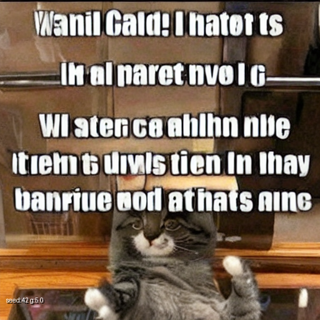

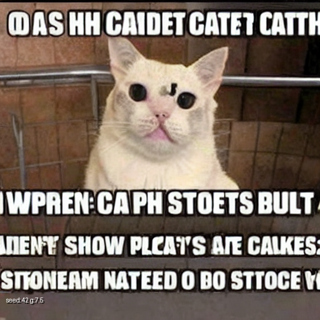

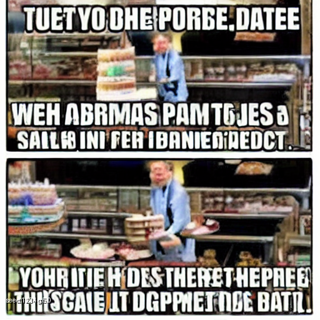

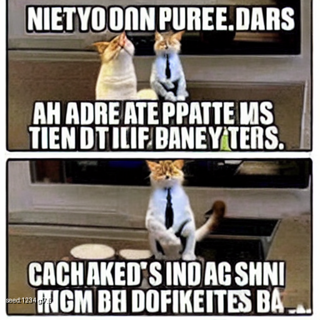

In [11]:
# Показать первые 4 результата (уменьшенные)
from PIL import Image
for r in results[:4]:
    display(Image.open(r[0]).resize((320,320)))